# Tratamento de dados

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exportação de vinho gaúcho

In [ ]:
# Importar base de dados de exportação de vinho de mesa
df_export = pd.read_csv('data/raw/vitibrasil-exportacao-vinho-de-mesa-1970-2024.csv', sep='\t')
df_export.head()

,Id,País,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,...,2020,2020.1,2021,2021.1,2022,2022.1,2023,2023.1,2024,2024.1
0,1,Afeganistão,0,0,0,0,0,0,0,0,...,0,0,11,46,0,0,0,0,0,0
1,2,África do Sul,0,0,0,0,0,0,0,0,...,4,21,0,0,0,0,117,698,103,1783
2,3,"Alemanha, República Democrática",0,0,0,0,4168,2630,12000,8250,...,6261,32605,2698,6741,7630,45367,4806,31853,6666,48095
3,4,Angola,0,0,0,0,0,0,0,0,...,0,0,0,0,4068,4761,0,0,0,0
4,5,Anguilla,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_export.shape

(141, 112)

In [6]:
# Dropar colunas desnecessárias para análise
df_export = df_export.drop(columns=['Id'])

# Renomear coluna para minúscula e sem acento
df_export = df_export.rename(columns={'País' : 'pais'})

# Identificar o que é quantidade e valor e criar uma coluna para ano
df_export = df_export.melt(id_vars=['pais'], var_name='ano_original', value_name='valor_quantidade')
df_export['ano'] = df_export['ano_original'].str.extract(r'(\d{4})').astype(int)
df_export['tipo'] = df_export['ano_original'].apply(lambda x: 'valor' if x.endswith('.1') else 'quantidade')

# Pivotar para criar coluna para quantidade e valor
df_export = df_export.pivot(index=['pais', 'ano'], columns='tipo', values='valor_quantidade').reset_index()

df_export.head()

tipo,pais,ano,quantidade,valor
0,Afeganistão,1970,0,0
1,Afeganistão,1971,0,0
2,Afeganistão,1972,0,0
3,Afeganistão,1973,0,0
4,Afeganistão,1974,0,0


In [ ]:
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7755 entries, 0 to 7754
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pais        7755 non-null   object
 1   ano         7755 non-null   int64 
 2   quantidade  7755 non-null   int64 
 3   valor       7755 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 242.5+ KB


In [ ]:
# Identificar quais países possuem vírgula no nome
df_export[df_export['pais'].str.contains(',')]['pais'].unique()

array(['Alemanha, República Democrática', 'Cayman, Ilhas',
       'Cocos (Keeling), Ilhas', 'Coreia, Republica Sul',
       'Eslovaca, Republica', 'Marshall, Ilhas', 'Tcheca, República'],
      dtype=object)

In [ ]:
# Tratar países com vírgula no nome
df_export['pais'] = df_export['pais'].apply(lambda x: ' '.join(reversed(x.split(', '))) if ', ' in x else x)
df_export[df_export['pais'].str.contains(',')]['pais'].unique()

array([], dtype=object)

In [ ]:
# Importar base com info de região e ISO3 de cada país
df_regiao = pd.read_csv('data/raw/paises_com_regiao_iso3.csv')
df_regiao.head()

,pais,regiao,iso3
0,Afeganistão,Ásia,AFG
1,África do Sul,África,ZAF
2,República Democrática Alemanha,Europa,DEU
3,Angola,África,AGO
4,Anguilla,América Central e Caribe,AIA


In [ ]:
# Juntar ambos DFs
df_export = df_export.merge(df_regiao, on='pais', how='left')
df_export.head()

,pais,ano,quantidade,valor,regiao,iso3
0,Afeganistão,1970,0,0,Ásia,AFG
1,Afeganistão,1971,0,0,Ásia,AFG
2,Afeganistão,1972,0,0,Ásia,AFG
3,Afeganistão,1973,0,0,Ásia,AFG
4,Afeganistão,1974,0,0,Ásia,AFG


In [ ]:
# Conferir se todos estão com ISO3
df_export[df_export['iso3'].isna()]['pais'].unique()

array(['Cingapura'], dtype=object)

In [ ]:
# Juntar dados de Singapura e Cingapura
df_export['pais'] = df_export['pais'].replace('Cingapura', 'Singapura')
df_export = df_export.groupby(['pais', 'ano'], as_index=False).sum()

In [ ]:
df_export.query('pais == "Singapura"').tail(5)

,pais,ano,quantidade,valor,regiao,iso3
6375,Singapura,2020,4049,9316,Ásia,SGP
6376,Singapura,2021,4504,14346,Ásia,SGP
6377,Singapura,2022,4322,15434,Ásia,SGP
6378,Singapura,2023,3941,19781,Ásia,SGP
6379,Singapura,2024,4141,20048,Ásia,SGP


In [ ]:
# Trocar nome da Alemanha que tá muito grande e fica feio nas visualizações kkk
df_export['pais'] = df_export['pais'].replace('República Democrática Alemanha', 'Alemanha')

In [ ]:
# Encontrar dados inconsistentes
df_export.query('quantidade == 0 and valor > 0')

,pais,ano,quantidade,valor,regiao,iso3
1315,Camarões,2020,0,178,África,CMR


In [ ]:
# Corrigir o valor com a média de litros exportada pelo país
media_camaroes = df_export.query('pais == "Camarões"')['quantidade'].mean().astype(int)
df_export.loc[(df_export["pais"] == "Camarões") & (df_export["ano"] == 2020), "quantidade"] = media_camaroes

In [ ]:
print(f"De {df_export['ano'].min()} a {df_export['ano'].max()}, um total de {df_export['pais'].nunique()} países importaram vinho de mesa do Rio Grande do Sul")

De 1970 a 2024, um total de 140 países importaram vinho de mesa do Rio Grande do Sul


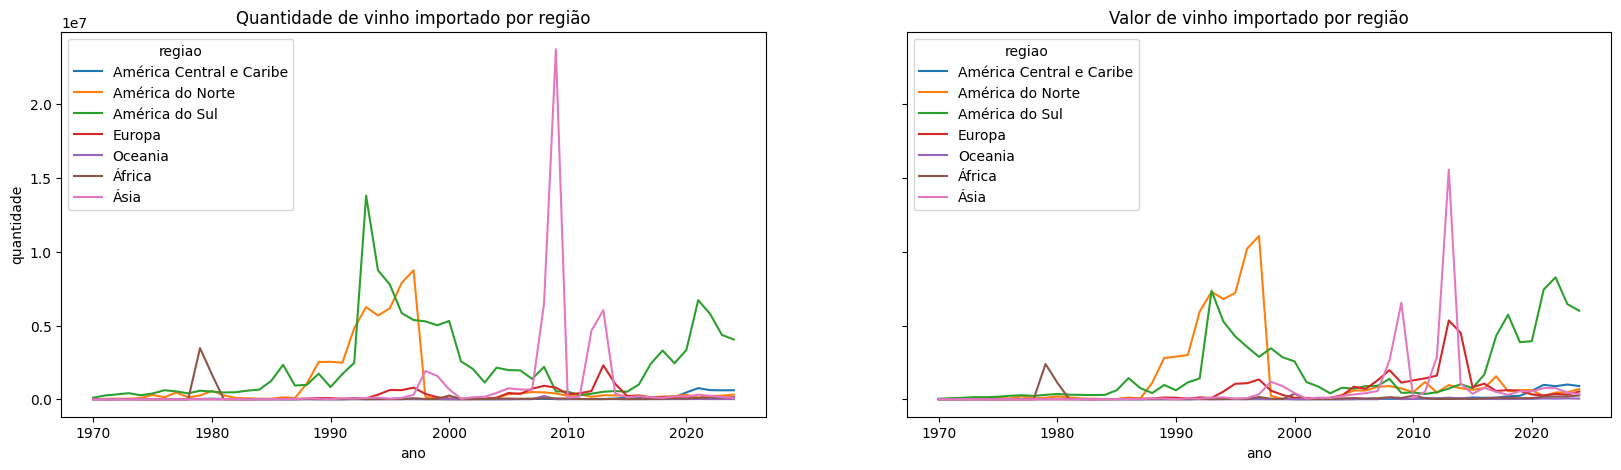

In [ ]:
exportacao_por_regiao = df_export.groupby(['regiao', 'ano'])[['quantidade', 'valor']].sum().reset_index()

# Gráfico de exportação por região
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

sns.lineplot(data=exportacao_por_regiao, x='ano', y='quantidade', hue='regiao', ax=axes[0])
sns.lineplot(data=exportacao_por_regiao, x='ano', y='valor', hue='regiao', ax=axes[1])

axes[0].set_title('Quantidade de vinho importado por região')
axes[1].set_title('Valor de vinho importado por região')

plt.show()

In [ ]:
# exportar CSV
# df_export.to_csv('data/processed/vitibrasil-exportacao-vinho-de-mesa-1970-2024-tratado.csv', index=False)

## Produção de vinho gaúcho

In [ ]:
df_producao = pd.read_csv('data/raw/vitibrasil-producao-1970-2023.csv', sep=';')
df_producao.head()

,id,control,produto,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,VINHO DE MESA,VINHO DE MESA,217208604,154264651,146953297,116710345,193875345,177401209,144565438,...,196173123,210308560,86319015,255015187,218375636,144629737,124200414,173899995,195031611,169762429
1,2,vm_Tinto,Tinto,174224052,121133369,118180926,88589019,146544484,144274134,118360170,...,157776363,169811472,75279191,1365957,188270142,121045115,103916391,146075996,162844214,139320884
2,3,vm_Branco,Branco,748400,1160500,1812367,243900,4138768,1441507,1871473,...,37438069,39557250,10727099,217527985,29229970,22032828,19568734,26432799,30198430,27910299
3,4,vm_Rosado,Rosado,42236152,31970782,26960004,27877426,43192093,31685568,24333795,...,958691,939838,312725,36121245,875524,1551794,715289,1391200,1988968,2531246
4,5,VINHO FINO DE MESA (VINIFERA),VINHO FINO DE MESA (VINIFERA),23899346,23586062,21078771,12368410,31644124,39424590,34500590,...,38464314,37148982,18070626,44537870,38707220,37615422,32516686,43474998,47511796,46268556


In [ ]:
# Encontrar as linhas de totais
df_producao[df_producao['control'].str.isupper()]

,id,control,produto,1970,1971,1972,1973,1974,1975,1976,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,1,VINHO DE MESA,VINHO DE MESA,217208604,154264651,146953297,116710345,193875345,177401209,144565438,...,196173123,210308560,86319015,255015187,218375636,144629737,124200414,173899995,195031611,169762429
4,5,VINHO FINO DE MESA (VINIFERA),VINHO FINO DE MESA (VINIFERA),23899346,23586062,21078771,12368410,31644124,39424590,34500590,...,38464314,37148982,18070626,44537870,38707220,37615422,32516686,43474998,47511796,46268556
8,9,SUCO,SUCO,1097771,2296654,3509440,0,0,0,0,...,76723537,87894468,42210389,77161971,65467906,77805352,69261287,100932264,65809079,67045238
14,15,DERIVADOS,DERIVADOS,14164329,13280518,12314509,28317919,47904934,53633143,22925012,...,62907281,107349704,53950314,109116761,95202101,142888747,92533804,169031493,138501226,174716647


In [ ]:
# Identificar o que é quantidade e valor e criar uma coluna para ano
df_producao = df_producao.melt(id_vars=['id', 'control', 'produto'], var_name='ano', value_name='quantidade')
df_producao['ano'] = df_producao['ano'].astype(int)
df_producao.head()

,id,control,produto,ano,quantidade
0,1,VINHO DE MESA,VINHO DE MESA,1970,217208604
1,2,vm_Tinto,Tinto,1970,174224052
2,3,vm_Branco,Branco,1970,748400
3,4,vm_Rosado,Rosado,1970,42236152
4,5,VINHO FINO DE MESA (VINIFERA),VINHO FINO DE MESA (VINIFERA),1970,23899346


In [ ]:
# Classificar tipo de produção
def classificar_producao(control):
    if control.startswith('vm'):
        return 'vinho de mesa'
    elif control.startswith('vv'):
        return 'vinho fino de mesa'
    elif control.startswith('su'):
        return 'suco'
    elif control.startswith('de'):
        return 'derivados'
    else:
        return None

# Retirando as linhas com os totais de cada tipo
df_producao['tipo'] = df_producao['control'].apply(classificar_producao)
df_producao = df_producao.dropna(subset=['tipo'])

df_producao.head()

,id,control,produto,ano,quantidade,tipo
1,2,vm_Tinto,Tinto,1970,174224052,vinho de mesa
2,3,vm_Branco,Branco,1970,748400,vinho de mesa
3,4,vm_Rosado,Rosado,1970,42236152,vinho de mesa
5,6,vv_Tinto,Tinto,1970,7591557,vinho fino de mesa
6,7,vv_Branco,Branco,1970,15562889,vinho fino de mesa


In [ ]:
df_producao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2538 entries, 1 to 2753
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          2538 non-null   int64 
 1   control     2538 non-null   object
 2   produto     2538 non-null   object
 3   ano         2538 non-null   int64 
 4   quantidade  2538 non-null   int64 
 5   tipo        2538 non-null   object
dtypes: int64(3), object(3)
memory usage: 138.8+ KB


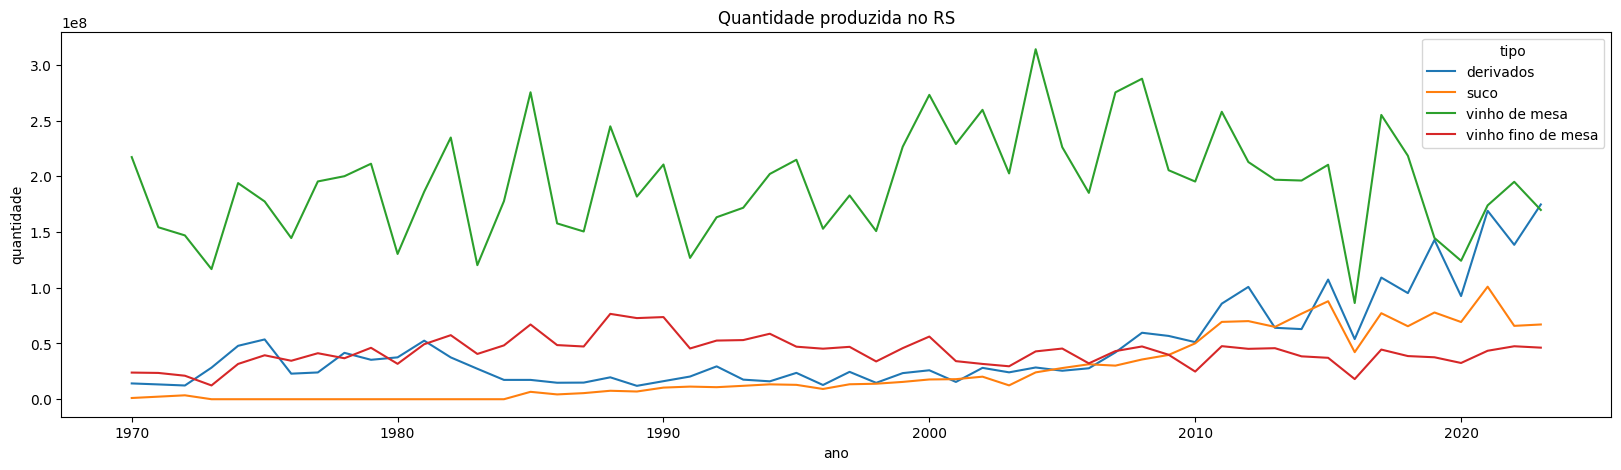

In [ ]:
df_producao_por_tipo = df_producao.groupby(['tipo', 'ano'])['quantidade'].sum().reset_index()

# Gráfico de produção por tipo
plt.figure(figsize=(20, 5))
sns.lineplot(data=df_producao_por_tipo, x='ano', y='quantidade', hue='tipo')

plt.title('Quantidade produzida no RS')
plt.show()

In [ ]:
# Filtrar apenas vinho de mesa
df_producao_vinho_mesa = df_producao.query('tipo == "vinho de mesa"')

# Dropar colunas desnecessárias para a análise
df_producao_vinho_mesa = df_producao_vinho_mesa.drop(columns=['control', 'tipo'])
df_producao_vinho_mesa.head()

,id,produto,ano,quantidade
1,2,Tinto,1970,174224052
2,3,Branco,1970,748400
3,4,Rosado,1970,42236152
52,2,Tinto,1971,121133369
53,3,Branco,1971,1160500


In [ ]:
ano_max = df_producao_vinho_mesa['ano'].max()
print(f"O Rio Grande do Sul produziu {df_producao_vinho_mesa.query('ano == @ano_max')['quantidade'].sum():,.0f} litros de vinho de mesa em {ano_max}")

O Rio Grande do Sul produziu 169,762,429 litros de vinho de mesa em 2023


In [ ]:
# exportar CSV
# df_producao_vinho_mesa.to_csv('data/processed/vitibrasil-producao-vinho-de-mesa-1970-2023-tratado.csv', index=False)

## Exportação de vinho mundial

In [ ]:
# Importar Excel de informação de vinho mundial
df_mundial = pd.read_excel('data/raw/OIV-WineDataBase.xlsx', sheet_name='Export', skipfooter=2)
df_mundial.head()

/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Continent,Region/Country,Product,Variable,Year,Unit,Quantity
0,Asia,Afghanistan,Wine,Consumption,1995,1000 hl,0
1,Asia,Afghanistan,Wine,Imports,1995,1000 hl,0
2,Asia,Afghanistan,Wine,Production,1995,1000 hl,0
3,Asia,Afghanistan,Wine,Consumption,1996,1000 hl,0
4,Asia,Afghanistan,Wine,Imports,1996,1000 hl,0


In [ ]:
df_mundial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22589 entries, 0 to 22588
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Continent       22589 non-null  object
 1   Region/Country  22589 non-null  object
 2   Product         22589 non-null  object
 3   Variable        22589 non-null  object
 4   Year            22589 non-null  int64 
 5   Unit            22589 non-null  object
 6   Quantity        22589 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.2+ MB


In [ ]:
# Colocar todas as colunas em letras minúsculas
df_mundial.columns = df_mundial.columns.str.lower()
df_mundial = df_mundial.rename(columns={'region/country': 'country'})

In [ ]:
# Converter hl para litros
df_mundial["quantidade_litro"] = df_mundial["quantity"] * 100_000

In [ ]:
# Apagar informação global
df_mundial = df_mundial[df_mundial['country'] != 'Global']

In [ ]:
# Apagar colunas desnecessárias
df_mundial = df_mundial[['continent', 'country', 'variable', 'year', 'quantidade_litro']]

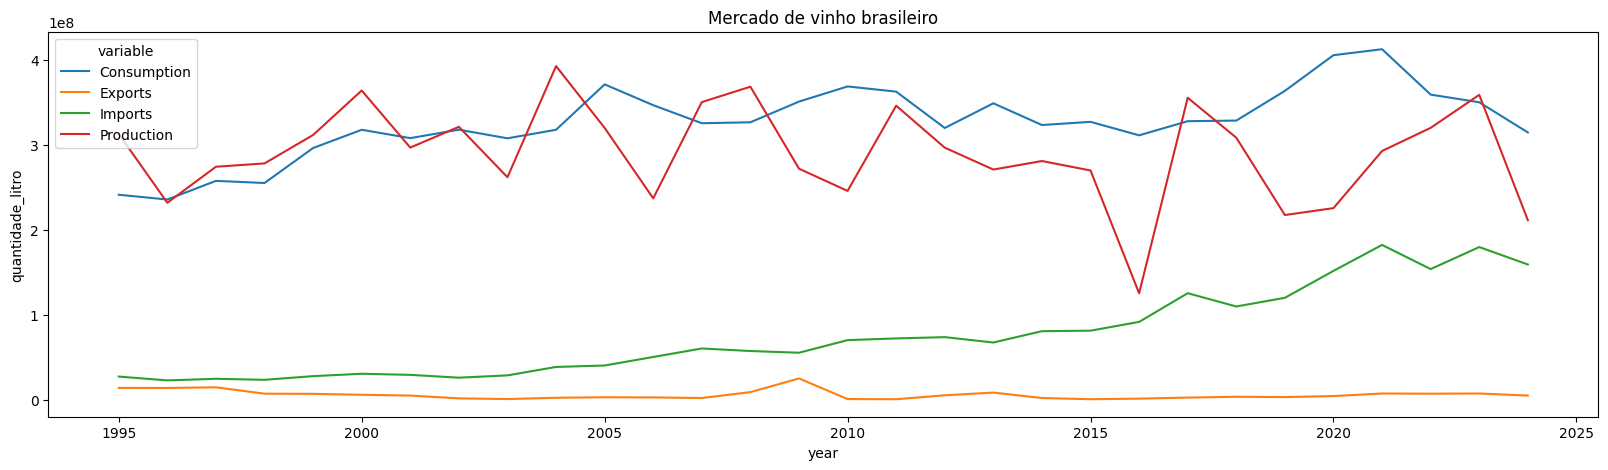

In [ ]:
df_brasil = df_mundial.query('country == "Brazil"')

# Gráfico do mercado de vinho brasileiro
plt.figure(figsize=(20, 5))
sns.lineplot(data = df_brasil, x='year', y='quantidade_litro', hue='variable')

plt.title('Mercado de vinho brasileiro')
plt.show()

In [ ]:
ano_escolhido = 2023
variables = df_mundial['variable'].unique()

for variable in variables:
  df = df_mundial.query('variable == @variable and year == @ano_escolhido').sort_values(by='quantidade_litro', ascending=False).reset_index(drop=True)
  posicao_brasil = df.query('country == "Brazil"').index[0] + 1
  print(f"Em {ano_escolhido}, o Brasil ocupa a posição {posicao_brasil} no ranking de {variable} mundial de vinho.")

Em 2023, o Brasil ocupa a posição 14 no ranking de Consumption mundial de vinho.
Em 2023, o Brasil ocupa a posição 13 no ranking de Imports mundial de vinho.
Em 2023, o Brasil ocupa a posição 14 no ranking de Production mundial de vinho.
Em 2023, o Brasil ocupa a posição 37 no ranking de Exports mundial de vinho.


In [ ]:
# exportar CSV
# df_mundial.to_csv('data/processed/ovi-vinho-1995-2024-tratado.csv', index=False)